# `CleanSamples` model

In [6]:
# Sconda conda activate tensorflow2; cd /mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/deeplift_analysis/; python

In [7]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)
from tensorflow.keras.initializers import GlorotUniform

from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from keras import backend as K

import sys
import pkg_resources

## Declare some constants

In [9]:
train = True
keras_model_json = "./clean_samples_model.json"
keras_model_weights = "./clean_samples_weights.h5"
OutputLayer = "sigmoid"

### Loading Datasets

In [10]:
if train:
    # Loading the dataset
    X = np.load(
        "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Train_X.npz"
    )["arr_0"].T
    Y = np.load(
        "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Train_Y.npz"
    )["arr_0"].T
    print(
        f"""
Training examples: {X.shape[0]}
X_train shape: {X.shape}
Y_train shape: {Y.shape}
"""
    )

X_dev = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Dev_X.npz"
)["arr_0"].T
Y_dev = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Dev_Y.npz"
)["arr_0"].T

X_test = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Test_X.npz"
)["arr_0"].T
Y_test = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Test_Y.npz"
)["arr_0"].T

print(
    f"""
Validation examples: {X_dev.shape[0]}
X_dev shape: {X_dev.shape}
Y_dev shape: {Y_dev.shape}

Test examples: {X_test.shape[0]}
X_dev shape: {X_test.shape}
Y_dev shape: {Y_test.shape}
"""
)


Training examples: 933009
X_train shape: (933009, 230)
Y_train shape: (933009, 1)


Validation examples: 64484
X_dev shape: (64484, 230)
Y_dev shape: (64484, 1)

Test examples: 65660
X_dev shape: (65660, 230)
Y_dev shape: (65660, 1)



## Sequential-style FCDNN

### Function to remove layer that is causing issues:

In [11]:
# Load the original JSON data
def json_remove_input_layer(json_file):
    # Read json
    with open(json_file, "r") as file:
        data = json.load(file)
        file.close()
    # Check if it has the problem and delete
    if (
        data["config"]["layers"]
        and data["config"]["layers"][0]["class_name"] == "InputLayer"
    ):
        del data["config"]["layers"][0]
        print("deleted 'InputLayer' layer config")
        # Save the modified data back to a new JSON file
        with open(json_file, "w") as file:
            json.dump(data, file, indent=4)
            file.close()
    else:
        print("Model does not contain 'InputLayer' in layer config")


# Remove the first layer from the 'layers' list within the 'config' key

### Function to make Keras model

In [12]:
# Make this a function to get a cleaner code:
def make_keras_model(X):
    keras_model = Sequential()
    keras_model.add(
        Dense(
            200,
            activation="relu",
            name="1",
            input_dim=X.shape[1],
            kernel_initializer=GlorotUniform(),
        )
    )
    keras_model.add(Dropout(0.15))
    keras_model.add(
        Dense(100, activation="relu", name="2", kernel_initializer=GlorotUniform())
    )
    keras_model.add(Dropout(0.15))
    keras_model.add(
        Dense(50, activation="relu", name="3", kernel_initializer=GlorotUniform())
    )
    keras_model.add(
        Dense(
            1, activation="sigmoid", name="Output", kernel_initializer=GlorotUniform()
        )
    )
    keras_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return keras_model

### Train Model

In [14]:
if train:
    # define the keras model
    clean_data_model = make_keras_model(X)
    clean_data_model.fit(x=X, y=Y, batch_size=1024, epochs=60)
    preds = clean_data_model.evaluate(x=X_dev, y=Y_dev)
    # serialize model to JSON
    model_json = clean_data_model.to_json()
    with open(keras_model_json, "w") as json_file:
        json_file.write(model_json)
        json_file.close()
    # Load back for formatting
    json_remove_input_layer(keras_model_json)
    # serialize weights to HDF5
    clean_data_model.save_weights("./clean_samples_weights.h5")
else:
    # load the keras model
    clean_data_model = model_from_json(open(keras_model_json).read())
    clean_data_model.load_weights(keras_model_weights)
    # Compile the model to configure the learning process.
    clean_data_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    preds = clean_data_model.evaluate(x=X_dev, y=Y_dev)  # 0.7899

# 4m 28s

2024-03-04 23:43:09.727903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 23:43:11.728650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-04 23:43:11.741062: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Epoch 1/60
912/912 [==============================] - 4s 4ms/step - loss: 0.8002 - accuracy: 0.6683
Epoch 2/60
912/912 [==============================] - 4s 4ms/step - loss: 0.5183 - accuracy: 0.7489
Epoch 3/60
912/912 [==============================] - 4s 5ms/step - loss: 0.5022 - accuracy: 0.7590
Epoch 4/60
912/912 [==============================] - 4s 5ms/step - loss: 0.4942 - accuracy: 0.7641
Epoch 5/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4897 - accuracy: 0.7674
Epoch 6/60
912/912 [==============================] - 4s 5ms/step - loss: 0.4867 - accuracy: 0.7692
Epoch 7/60
912/912 [==============================] - 4s 5ms/step - loss: 0.4836 - accuracy: 0.7712
Epoch 8/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4824 - accuracy: 0.7717
Epoch 9/60
912/912 [==============================] - 4s 5ms/step - loss: 0.4799 - accuracy: 0.7739
Epoch 10/60
912/912 [==============================] - 4s 5ms/step - loss: 0.4788 - accuracy: 0.7745

In [15]:
def test_and_auc(
    keras_model,
    X_test,
    Y_test,
    save_prob: bool = True,
    prin_auc_plot: bool = True,
    sample_name="Clean Samples",
    out_file="./roc_curve_CleanSamples.png",
):
    preds = keras_model.evaluate(x=X_test, y=Y_test)
    ProbableValues = keras_model.predict(X_test)
    Obs = pd.Series(Y_test.flatten().astype(int))
    Pred = pd.Series(ProbableValues.round().flatten().astype(int))
    Prob = pd.Series(ProbableValues.flatten().astype(float))
    Side2Prob = pd.concat([Obs, Pred, Prob], axis=1)
    Side2Prob.columns = ["Observed", "Predicted", "Probability"]
    if save_prob:
        Side2Prob.to_feather(
            "./Probabilities_Keras_CleanSamples_e60_L200_100_50_1.feather"
        )
        Side2Prob.to_csv(
            "./Probabilities_Keras_CleanSamples_e60_L200_100_50_1.csv", index=False
        )

    fpr, tpr, _ = roc_curve(Obs, Prob)
    auc_score = roc_auc_score(Obs, Prob)

    print(
        """
Accuracy:    %.4f
Precision:   %.4f
Recall:      %.4f
F1 score:    %.4f
AUC Score:   %.4f
"""
        % (
            preds[1],
            precision_score(Obs, Pred),
            recall_score(Obs, Pred),
            f1_score(Obs, Pred),
            auc_score,
        )
    )
    if prin_auc_plot:
        font_name = "Nimbus Roman"
        # downsample points to plot if too large
        num_points = min(len(tpr), 1000)
        fpr_interp = np.linspace(0, 1, num_points)
        tpr_interp = np.interp(fpr_interp, fpr, tpr)
        plt.rcParams["font.family"] = "Nimbus Roman"

        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        # Create the plot with Seaborn
        plt.figure(figsize=(8, 6))
        sns.lineplot(
            x=fpr_interp,
            y=tpr_interp,
            label=f"Model (AUC = {auc_score:.2f})",
            linewidth=2,
        )
        ax = sns.lineplot(
            x=[0, 1],
            y=[0, 1],
            linestyle="--",
            label="No learning",
            color="tab:gray",
        )

        # Customizing the plot to make it more suitable for publication
        title_fontsize = 16 * 1.3  # 2x the base size for labels
        label_fontsize = 16 * 1.5  # 2x the base size for labels
        tick_fontsize = 12 * 2  # 2x the base size for ticks
        ax.set_title(
            f"ROC Curve: {sample_name}", fontsize=title_fontsize, fontname=font_name
        )
        ax.set_xlabel(
            "False Positive Rate (FPR)", fontsize=label_fontsize, fontname=font_name
        )
        ax.set_ylabel(
            "True Positive Rate (TPR)", fontsize=label_fontsize, fontname=font_name
        )
        plt.xticks(fontsize=tick_fontsize, fontname=font_name)
        plt.yticks(fontsize=tick_fontsize, fontname=font_name)
        plt.legend(loc="best", fontsize=14)
        plt.tight_layout()
        # Save the plot
        plt.savefig(out_file, dpi=300)
        # Show the plot
        plt.show()

    return Side2Prob

### Get AUC metrics per sample

In [16]:
def get_auc_f1(
    keras_model,
    X_test,
    Y_test,
):

    ProbableValues = keras_model.predict(X_test)
    Obs = pd.Series(Y_test.flatten().astype(int))
    Prob = pd.Series(ProbableValues.flatten().astype(float))
    Pred = pd.Series(ProbableValues.round().flatten().astype(int))
    auc_score = round(roc_auc_score(Obs, Prob), 4)
    f1 = round(f1_score(Obs, Pred), 4)

    return auc_score, f1

In [17]:
def load_test_set(data_dir, sample):
    preffix = os.path.join(data_dir, sample)
    X_test = np.load(preffix + "_Test_X.npz")["arr_0"].T
    Y_test = np.load(preffix + "_Test_Y.npz")["arr_0"].T
    return X_test, Y_test

In [18]:
data_dir = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B"

sample_names = pd.read_csv(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/filtered_files_surnames.csv",
    header=None,
)[7].tolist()

# Load trained model:
keras_model_json = "./clean_samples_model.json"
keras_model_weights = "./clean_samples_weights.h5"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [19]:
# output results variable
auc_results = []
f1_results = []
for i, sample in enumerate(sample_names):
    # load data:
    X_test, Y_test = load_test_set(data_dir, sample)
    auc, f1 = get_auc_f1(keras_model, X_test, Y_test)
    auc_results.append(auc)
    f1_results.append(f1)

In [28]:
print("\n".join(sample_names))

mm10_Bcell_Activated_24_Rep1
mm10_Bcell_Activated_48_Rep1
mm10_Bcell_Activated_72_Rep1
mm10_Bcell_Resting_Rep1
mm10_Bergmann_Glia_Rep2
mm10_CD4_Naive_Tcell_Rep2
mm10_CD4_SinglePositive_Tcell_Rep1
mm10_CD8_Naive_Tcell_Rep2
mm10_CD8_SinglePositive_Tcell_Rep2
mm10_Cardiomyocites_Adult_Rep1
mm10_Cardiomyocites_TAC_Rep2
mm10_Colon_Epithelia_Rep2
mm10_DoublePositive_Tcell_Rep2
mm10_E13_Frontal_Cortex_Rep1
mm10_E14_mESC_Rep3
mm10_Female_Cerebellum_Rep1
mm10_Female_Cortex_Rep1
mm10_Female_Hippocampus_Rep1
mm10_Female_Hypothalamus_Rep1
mm10_Female_Thalamus_Rep1
mm10_Granule_Cells_Rep1
mm10_Hematopo_CommonMyeloydProgenitor_Rep1
mm10_Hematopo_Granulocyte_Monocyte_Progenitor_Rep1
mm10_Hematopo_LSK_Rep1
mm10_Hematopo_Megakaryocitic_Erythroyd_Progenitor_Rep1
mm10_Hematopoietic_Stem_Cells_Rep1
mm10_Intestinal_Epithelial_Sox_High_Rep3
mm10_Leukemia_Granulocyte_Monocyte_Progenitor_Rep5
mm10_Leukemia_Multipotent_Progenitors_Rep2
mm10_Liver_Rep1
mm10_MEF_Rep3
mm10_Male_Cerebellum_Rep1
mm10_Male_Cortex_Re

In [18]:
# NOTE: # Backup don't run
round(pd.DataFrame(auc_results).describe(), 4)

,0
count,49.0000
mean,0.8937
std,0.0388
min,0.7304
25%,0.8823
50%,0.8995
75%,0.9157
max,0.9513


In [20]:
# NOTE: Dont delete' this is proof that using test to evaluate the model during training messes things up.
round(pd.DataFrame(auc_results).describe(), 4)

,0
count,49.0000
mean,0.8569
std,0.0455
min,0.6705
25%,0.8437
50%,0.8555
75%,0.8849
max,0.9298


In [21]:
round(pd.DataFrame(f1_results).describe(), 4)

,0
count,49.0000
mean,0.8028
std,0.0532
min,0.5786
25%,0.7911
50%,0.8169
75%,0.8328
max,0.8764


In [30]:
used_cells = pd.DataFrame(sample_names, columns=["cells"])
used_cells.cells = used_cells.cells.str.replace("mm10_", "")
used_cells

,cells
0,Bcell_Activated_24_Rep1
1,Bcell_Activated_48_Rep1
2,Bcell_Activated_72_Rep1
3,Bcell_Resting_Rep1
4,Bergmann_Glia_Rep2
5,CD4_Naive_Tcell_Rep2
6,CD4_SinglePositive_Tcell_Rep1
7,CD8_Naive_Tcell_Rep2
8,CD8_SinglePositive_Tcell_Rep2
9,Cardiomyocites_Adult_Rep1


In [31]:
print("\n".join(map(str, auc_results)))

0.9092
0.9211
0.9183
0.9157
0.8823
0.9433
0.9158
0.9433
0.9475
0.8404
0.8079
0.9327
0.8875
0.8525
0.862
0.888
0.8909
0.9045
0.9049
0.8995
0.9168
0.9031
0.8987
0.8972
0.9123
0.8734
0.9213
0.8811
0.8898
0.9125
0.8276
0.9088
0.8861
0.8714
0.8995
0.8999
0.8972
0.9392
0.9087
0.9065
0.9417
0.7304
0.8859
0.869
0.845
0.9513
0.8625
0.9022
0.8861


In [34]:
print("\n".join(map(str, f1_results)))

0.7911
0.8328
0.8245
0.8048
0.8133
0.8631
0.8115
0.8764
0.8309
0.7459
0.69
0.8553
0.7226
0.7245
0.7706
0.806
0.8141
0.8213
0.8237
0.8242
0.8375
0.8204
0.7948
0.8198
0.8169
0.7818
0.8486
0.7767
0.7739
0.8147
0.7029
0.835
0.8046
0.8006
0.8257
0.8224
0.8099
0.8635
0.837
0.8379
0.8626
0.5786
0.8185
0.7919
0.7547
0.8613
0.7361
0.8427
0.8185


### Plot metrics

In [33]:
if train:
    _ = test_and_auc(clean_data_model, X_dev, Y_dev)
# Accuracy:    0.7927
# Precision:   0.8175
# Recall:      0.7884
# F1 score:    0.8027
# AUC Score:   0.8703

## Test Loading model


Accuracy:    0.7944
Precision:   0.8146
Recall:      0.7970
F1 score:    0.8057
AUC Score:   0.8712



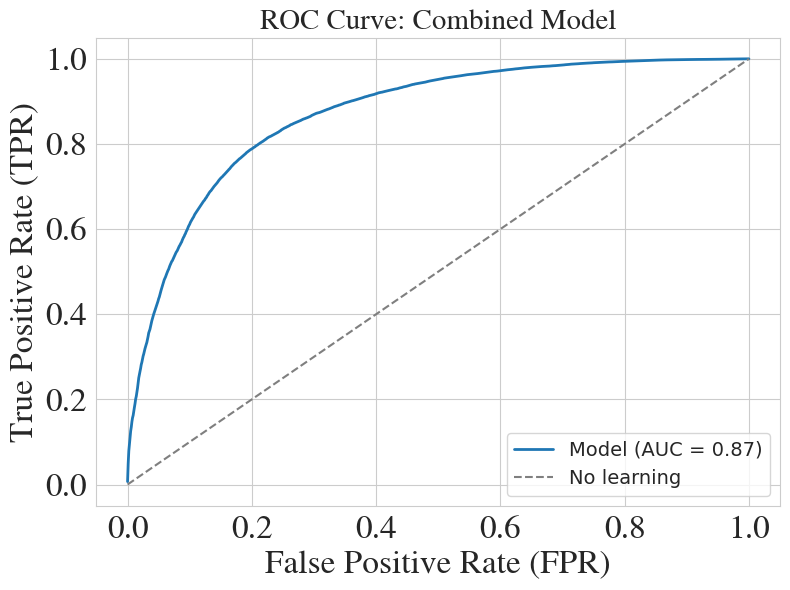

In [34]:
# load the keras model
keras_model_json = "./clean_samples_model.json"
keras_model_weights = "./clean_samples_weights.h5"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
Side2Prob = test_and_auc(
    keras_model,
    X_dev,
    Y_dev,
    prin_auc_plot=True,
    save_prob=False,
    sample_name="Combined Model",
)

In [35]:
Side2Prob.to_csv(
    "./Probabilities_Keras_CleanSamples_e60_L200_100_50_1.csv", index=False
)

## Obtain the value that generates a neutral response

In [36]:
# Initialize variables
min_diff = float("inf")
neutral_value = 0

# Prepare the entire range of input values
input_values = np.arange(-10, 10, 0.01)
input_array = np.full(
    (input_values.size, 230), input_values.reshape(-1, 1), dtype=np.float32
)

# Predict for all input values in a single pass
sigma_values = keras_model.predict(input_array, batch_size=200).flatten()
diffs = np.abs(sigma_values - 0.5)

# Find the value that produces the sigma closest to 0.5
min_diff_idx = np.argmin(diffs)
min_diff = diffs[min_diff_idx]
neutral_value = input_values[min_diff_idx]

# Predict using the neutral value found
sigma_value = float(
    keras_model.predict(np.full((1, 230), neutral_value), batch_size=200)
)

# Output results
print(f"Neutral Reference: {neutral_value:.4f}\nSigma: {sigma_value}")

# Prepare the neutral reference input array for further use
NeuRef = np.full((1, 230), neutral_value, dtype=np.float32)

Neutral Reference: 3.8600
Sigma: 0.4997701048851013


# Print packages used

In [37]:
def get_imported_packages_with_versions():
    imported_packages = set(
        [module.split(".")[0] for module in sys.modules.keys() if module.split(".")[0]]
    )
    imported_packages_with_versions = {}

    for pkg in imported_packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            imported_packages_with_versions[pkg] = version
        except (
            pkg_resources.DistributionNotFound,
            pkg_resources.ExtractionError,
            pkg_resources.VersionConflict,
            Exception,
        ):
            # Skip packages that cause issues
            pass

    return imported_packages_with_versions


imported_packages_with_versions = get_imported_packages_with_versions()

# Print the package names and their versions
for pkg, version in imported_packages_with_versions.items():
    print(f"{pkg}: {version}")

setuptools: 69.0.3
seaborn: 0.12.2
black: 24.1.1
keras_preprocessing: 1.1.2
executing: 2.0.1
prompt_toolkit: 3.0.42
requests: 2.31.0
matplotlib_inline: 0.1.6
flatbuffers: 1.12
idna: 3.6
termcolor: 2.4.0
stack_data: 0.6.2
ptyprocess: 0.7.0
jupyter_core: 5.7.1
opt_einsum: 3.3.0
pickleshare: 0.7.5
six: 1.16.0
tensorboard: 2.4.1
pyparsing: 3.1.1
pytz: 2024.1
scipy: 1.9.3
importlib_metadata: 7.0.1
traitlets: 5.14.1
urllib3: 2.2.0
parso: 0.8.3
IPython: 8.12.2
jupyter_client: 8.6.0
joblib: 1.3.2
zipp: 3.17.0
keras: 2.4.3
certifi: 2024.2.2
cffi: 1.16.0
psutil: 5.9.8
packaging: 23.2
jedi: 0.19.1
tomli: 2.0.1
pure_eval: 0.2.2
pygments: 2.17.2
brotli: 1.1.0
pandas: 1.3.5
cycler: 0.12.1
pathspec: 0.12.1
decorator: 5.1.1
click: 8.1.7
tensorflow: 2.4.0
pexpect: 4.9.0
tornado: 6.4
backcall: 0.2.0
asttokens: 2.4.1
debugpy: 1.8.1
typing_extensions: 4.9.0
threadpoolctl: 3.2.0
pyarrow: 3.0.0
wrapt: 1.16.0
platformdirs: 4.2.0
mypy_extensions: 1.0.0
charset_normalizer: 3.3.2
h5py: 2.10.0
kiwisolver: 1.4.5


In [38]:
json_remove_input_layer("./clean_samples_model_mac.json")

Model does not contain 'InputLayer' in layer config


# Train Model - extensively and plot acc and loss

## Declare some constants

In [11]:
train = True
keras_model_json = "./clean_samples_1000epochs_model.json"
keras_model_weights = "./clean_samples_1000epochs_weights.h5"
OutputLayer = "sigmoid"

In [17]:
# clean session
K.clear_session()
# define the keras model
clean_data_model = make_keras_model(X)
history = clean_data_model.fit(x=X, y=Y, batch_size=1024, epochs=1000)
# serialize model to JSON
model_json = clean_data_model.to_json()
with open(keras_model_json, "w") as json_file:
    json_file.write(model_json)
    json_file.close()
# Load back for formatting
json_remove_input_layer(keras_model_json)
# serialize weights to HDF5
clean_data_model.save_weights(keras_model_weights)

Epoch 1/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.6062 - accuracy: 0.6995
Epoch 2/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.5068 - accuracy: 0.7557
Epoch 3/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.4948 - accuracy: 0.7629
Epoch 4/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.4889 - accuracy: 0.7678
Epoch 5/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.4852 - accuracy: 0.7702
Epoch 6/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.4830 - accuracy: 0.7714
Epoch 7/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.4804 - accuracy: 0.7728
Epoch 8/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.4794 - accuracy: 0.7734
Epoch 9/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.4774 - accuracy: 0.7754
Epoch 10/1000
912/912 [==============================] - 4s 4ms/step - loss: 0.475

In [35]:
import pickle

# Saving the history object
with open(
    f"model_history_to_show_what_if_high_epochs_clean_samples_1000epochs.pkl", "wb"
) as file_pi:
    pickle.dump(history.history, file_pi)

# # Later, to load the history object
# with open('model_history.pkl', 'rb') as file_pi:
#     loaded_history = pickle.load(file_pi)

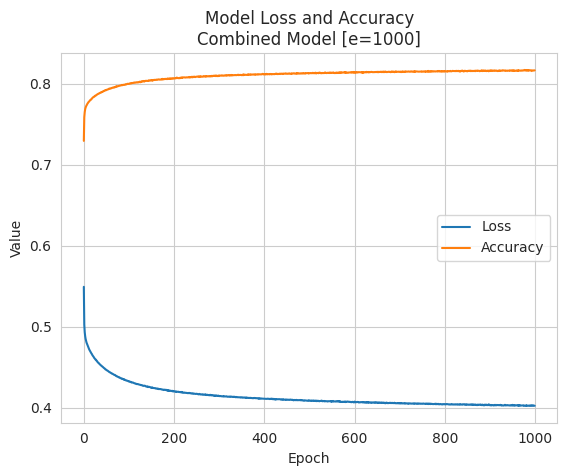

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Loss")
if "accuracy" in history.history:
    plt.plot(history.history["accuracy"], label="Accuracy")
elif "acc" in history.history:  # For older versions of Keras
    plt.plot(history.history["acc"], label="Accuracy")

plt.title("Model Loss and Accuracy\nCombined Model [e=1000]")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend()
plt.show()

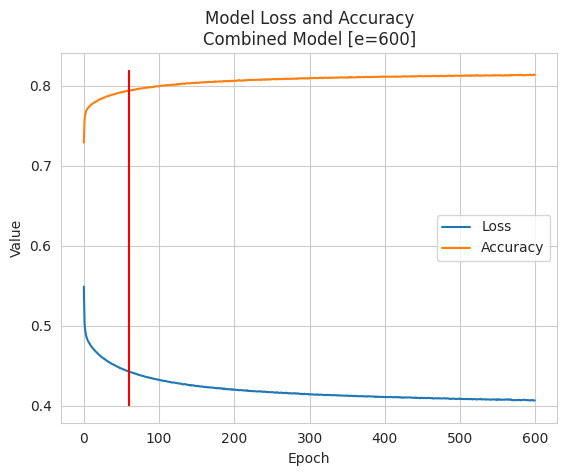

In [33]:
epochs = 600
plt.plot(history.history["loss"][0:epochs], label="Loss")
if "accuracy" in history.history:
    plt.plot(history.history["accuracy"][0:epochs], label="Accuracy")
elif "acc" in history.history:  # For older versions of Keras
    plt.plot(history.history["acc"][0:epochs], label="Accuracy")

plt.title(f"Model Loss and Accuracy\nCombined Model [e={epochs}]")
plt.vlines(x=60, ymin=0.4, ymax=0.82, colors="red")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend()
plt.show()

2052/2052 [==============================] - 1s 507us/step - loss: 0.4799 - accuracy: 0.7731

Accuracy:    0.7658
Precision:   0.7743
Recall:      0.7604
F1 score:    0.7673
AUC Score:   0.8440



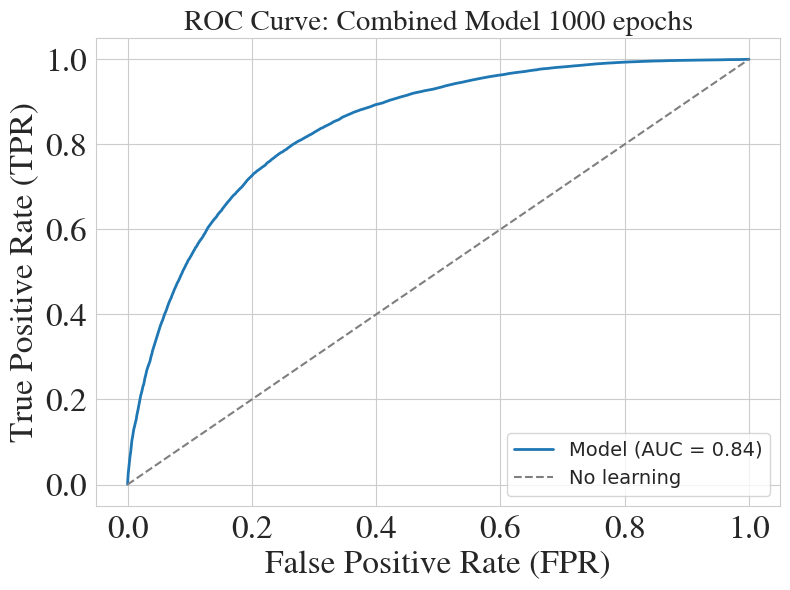

In [24]:
keras_model_json = "./clean_samples_1000epochs_model.json"
keras_model_weights = "./clean_samples_1000epochs_weights.h5"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
Side2Prob = test_and_auc(
    keras_model,
    X_test,
    Y_test,
    prin_auc_plot=True,
    save_prob=False,
    sample_name="Combined Model 1000 epochs",
)